In [1]:
import requests
import pandas as pd
import networkx as nx
import requests_cache
requests_cache.install_cache('demo_cache')

In [2]:
MASST_TASK = "c6b2797224f34d819d20dd7af622bc6b"

In [3]:
# Loading MASST information

spectra_matches_df = pd.read_csv("https://gnps.ucsd.edu/ProteoSAFe/DownloadResultFile?task={}&file=all_dataset_spectra_matches/&block=main".format(MASST_TASK), sep="\t")
spectra_matches_df.head()

,cluster_scan,dataset_id,filename,filescan,metadata
0,1698,MSV000078635,f.MSV000078635/ccms_peak/Large_Pseudomonas_v2/...,769,
1,1698,MSV000078635,f.MSV000078635/ccms_peak/Large_Pseudomonas_v2/...,780,
2,1698,MSV000078635,f.MSV000078635/ccms_peak/Large_Pseudomonas_v2/...,781,
3,1698,MSV000078635,f.MSV000078635/ccms_peak/Large_Pseudomonas_v2/...,769,
4,1698,MSV000078635,f.MSV000078635/ccms_peak/Large_Pseudomonas_v2/...,780,


In [4]:
dataset_matches = list(set(spectra_matches_df["dataset_id"]))
all_datasets = requests.get("https://massive.ucsd.edu/ProteoSAFe/datasets_json.jsp#%7B%22query%22%3A%7B%7D%2C%22table_sort_history%22%3A%22createdMillis_dsc%22%7D").json()["datasets"]

MSV000078602
[3720, 3721]
8
MSV000078709
[125, 126]
5
MSV000078635
[1698]
1
MSV000079450
[1881]
1
MSV000078937
[2884]
1
MSV000078547
[1906, 1907, 1908]
11
MSV000078552
[3203, 3206]
14
MSV000079140
[1492]
8
usi {'usi': 'mzspec:GNPS:TASK-f1259022e3774132a3a114fbb5a4f200-speccontinuous/speccontinuous-00000.mgf:scan:1492', 'node_id': 'MSV000078602:3746'}
usi {'usi': 'mzspec:GNPS:TASK-f1259022e3774132a3a114fbb5a4f200-speccontinuous/speccontinuous-00000.mgf:scan:1492', 'node_id': 'MSV000078602:3697'}
usi {'usi': 'mzspec:GNPS:TASK-f1259022e3774132a3a114fbb5a4f200-speccontinuous/speccontinuous-00000.mgf:scan:1492', 'node_id': 'MSV000078602:3776'}
usi {'usi': 'mzspec:GNPS:TASK-f1259022e3774132a3a114fbb5a4f200-speccontinuous/speccontinuous-00000.mgf:scan:1492', 'node_id': 'MSV000078602:3721'}
usi {'usi': 'mzspec:GNPS:TASK-f1259022e3774132a3a114fbb5a4f200-speccontinuous/speccontinuous-00000.mgf:scan:1492', 'node_id': 'MSV000078602:3746'}
usi {'usi': 'mzspec:GNPS:TASK-f1259022e3774132a3a114fbb5a4f

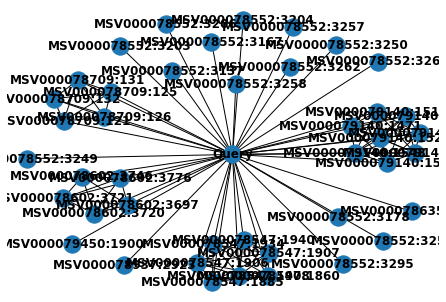

In [45]:
G = nx.Graph()
G.add_node("Query")

all_node_usi_list = []

for dataset in dataset_matches:
    print(dataset)
    filtered_dataset = [current_dataset for current_dataset in all_datasets if current_dataset["dataset"] == dataset]
    dataset_task = filtered_dataset[0]["task"]
    continuous_id = requests.get("http://gnps.ucsd.edu/ProteoSAFe/ContinuousIDServlet?task={}".format(dataset_task)).json()
    
    network_url = "https://gnps.ucsd.edu/ProteoSAFe/result_json.jsp?task={}&view=clusters_network_pairs".format(continuous_id["jobs"][0]["task"])
    data = requests.get(network_url).json()['blockData']
    network_df = pd.DataFrame(data)
    
    dataset_spectra_matches = spectra_matches_df[spectra_matches_df["dataset_id"] == dataset]
    clusters_matched = list(set(dataset_spectra_matches["cluster_scan"]))
    print(clusters_matched)
    
    network_df["Node1"] = network_df["Node1"].astype(int)
    filtered_edges = network_df[network_df["Node1"].isin(clusters_matched)]
    print(len(filtered_edges))
    
    for edge in filtered_edges.to_dict(orient="records"):
        node_id = "{}:{}".format(dataset, edge["Node2"])
        G.add_node(node_id)
        # Adding an edge
        G.add_edge("Query", node_id)
        
        usi = "mzspec:GNPS:TASK-{}-speccontinuous/speccontinuous-00000.mgf:scan:{}".format(continuous_id["jobs"][0]["task"], cluster)
        all_node_usi_list.append({"usi":usi, "node_id": node_id})

# Adding edges to node
for i, usi1 in enumerate(all_node_usi_list):
    for j, usi2 in enumerate(all_node_usi_list):
        if i <= j:
            continue
        comparison_url = "http://mingwangbeta.ucsd.edu:5087/mirrorjson/?usi1={}&usi2={}&cosine=shifted&fragment_mz_tolerance=1".format(usi1["usi"], usi2["usi"])        
        r = requests.get(comparison_url)
        comparison_json = r.json()
        if r.status_code != 200:
            continue
        if "cosine" in comparison_json:
            cosine = comparison_json["cosine"]

            if cosine > 0.9:
                G.add_edge(usi1["node_id"], usi2["node_id"])

            
# Adding more Node information to network
for usi in all_node_usi_list:
    print("usi", usi)
    url = "http://mingwangbeta.ucsd.edu:5087/json/?usi={}".format(usi["usi"])
    spectrum_details = requests.get(url).json()
    #print(spectrum_details)
    try:
        G.nodes[usi["node_id"]]["mz"] = spectrum_details["precursor_mz"]
    except:
        print(url)
        continue

print(len(G))
nx.draw(G, with_labels=True, font_weight='bold')

In [46]:
import ipycytoscape

cytoscapeobj = ipycytoscape.CytoscapeWidget()
cytoscapeobj.graph.add_graph_from_json(nx.cytoscape_data(G)["elements"])
cytoscapeobj.set_style([{
                        'selector': 'node',
                        'css': {
                            'content': 'data(mz)',
                            'text-valign': 'center',
                            'color': 'black',
                            'text-outline-width': 0,
                            'text-outline-color': 'green',
                            'background-color': 'green'
                        }
                        },
                        {
                        'selector': ':selected',
                        'css': {
                            'background-color': 'black',
                            'line-color': 'black',
                            'target-arrow-color': 'black',
                            'source-arrow-color': 'black',
                            'text-outline-color': 'black'
                        }}
                        ])
cytoscapeobj

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'css': {'content': 'd…

In [10]:
all_datasets[0]

{'dataset': 'MSV000086270',
 'datasetNum': '86270',
 'title': 'GNPS U19_ADNI_Go2 LCMS Metabolomics Sample Cohort',
 'user': 'mjmeehan',
 'site': 'MassIVE',
 'flowname': 'MASSIVE-COMPLETE',
 'createdMillis': '1602520766000',
 'created': 'Oct. 12, 2020, 9:39 AM',
 'description': 'U19 Metabolomics Samples from the ADNI_Go2 data set run on the Q-Exactive mass spectrometer.',
 'fileCount': '2424',
 'fileSizeKB': '101239741',
 'spectra': '0',
 'psms': '0',
 'peptides': '0',
 'variants': '0',
 'proteins': '0',
 'search_psms': '0',
 'search_peptides': '0',
 'search_variants': '0',
 'search_proteins': '0',
 'search_spectra': '0',
 'reanalysis_psms': '0',
 'reanalysis_peptides': '0',
 'reanalysis_variants': '0',
 'reanalysis_proteins': '0',
 'species': 'Homo sapiens (NCBITaxon:9606)',
 'instrument': 'Q Exactive',
 'modification': 'MS:1002864 - No post-translational-modifications are included in the identified peptides of this dataset',
 'keywords': 'ADNI-GO2',
 'pi': [{'name': 'Pieter C Dorreste